# Two-Level: Collision of Two 2π Pulses

Time taken to solve this problem on a 2013 MacBook Pro: 3m.

In [1]:
import numpy as np

sech_fwhm_conv = 1./2.6339157938
t_width_1 = 2.0*sech_fwhm_conv # [τ]

print('t_width', t_width_1)

n = 2.0 # For a pulse area of nπ    
ampl_1 = n/t_width_1/(2*np.pi) # Pulse amplitude [2π Γ]

print('ampl_1', ampl_1)

t_width 0.7593257175145156
ampl_1 0.41920071827108335


In [2]:
t_width_2 = 1.0*sech_fwhm_conv # [τ]
ampl_2 = n/t_width_2/(2*np.pi)

print('t_width_2', t_width_2)
print('ampl_2', ampl_2)

t_width_2 0.3796628587572578
ampl_2 0.8384014365421667


In [3]:
mb_solve_json = """
{
  "ob_atom": {
    "decays": [
      {
        "channels": [[0, 1]],
        "rate": 0.0
      }
    ],
    "energies": [],
    "fields": [
      {
        "coupled_levels": [[0, 1]],
        "detuning": 0.0,
        "detuning_positive": true,
        "label": "probe",
        "rabi_freq": 1.0,
        "rabi_freq_t_args": {
          "ampl_1": 1.0,
          "centre_1": 0.0,
          "width_1": 0.7593257175145156
        },
        "rabi_freq_t_func": "sech_1"
      }
    ],
    "num_states": 2
  },
  "t_min": -5.0,
  "t_max": 25.0,
  "t_steps": 300,
  "z_min": -0.2,
  "z_max": 1.2,
  "z_steps": 140,
  "z_steps_inner": 2,
  "num_density_z_func": "square_1",
  "num_density_z_args": {
    "on_1": 0.0,
    "off_1": 1.0,
    "ampl_1": 1.0
  },
  "interaction_strengths": [
    10.0
  ],
  "velocity_classes": {
    "thermal_delta_min": -0.0,
    "thermal_delta_max": 0.0,
    "thermal_delta_steps": 0,
    "thermal_delta_inner_min": 0.0,
    "thermal_delta_inner_max": 0.0,
    "thermal_delta_inner_steps": 0,
    "thermal_width": 1.0
  },
  "method": "mesolve",
  "opts": {},
  "savefile": "qu/mb-solve-two-sech-2pi-collision"
}
"""

In [4]:
from maxwellbloch import mb_solve
mb_solve_00 = mb_solve.MBSolve().from_json_str(mb_solve_json)

In [5]:
from maxwellbloch import t_funcs

probe_field = mb_solve_00.ob_atom.fields[0]

two_pulse_t_func = lambda t, args: (t_funcs.sech_1(t, args) +
                                    t_funcs.sech_2(t, args))


probe_field.rabi_freq_t_func = two_pulse_t_func

probe_field.rabi_freq_t_args = {"ampl_2": ampl_2, "centre_2": 5.0,
 "width_2": t_width_2, "ampl_1": ampl_1, "centre_1": 0.0,
 "width_1": t_width_1}

mb_solve_00.ob_atom.build_H_Omega(); # We have to rebuild H_Omega

mb_solve_00.init_Omegas_zt();

We'll just check that the pulse area is what we want. Should be 4π

In [6]:
print('The input pulse area is {0:.4f}π'.format(np.trapz(mb_solve_00.Omegas_zt[0,0,:].real, 
                                                     mb_solve_00.tlist)/np.pi))

The input pulse area is 3.9982π


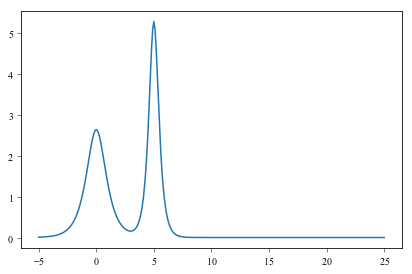

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(mb_solve_00.tlist, np.abs(mb_solve_00.Omegas_zt[0,0,:]))

## Solve the Problem

In [8]:
%time Omegas_zt, states_zt = mb_solve_00.mbsolve(step='ab', recalc=False, pbar_chunk_size=10)

Loaded tuple object.
CPU times: user 2.36 ms, sys: 5.08 ms, total: 7.44 ms
Wall time: 6.57 ms


## Plot Output

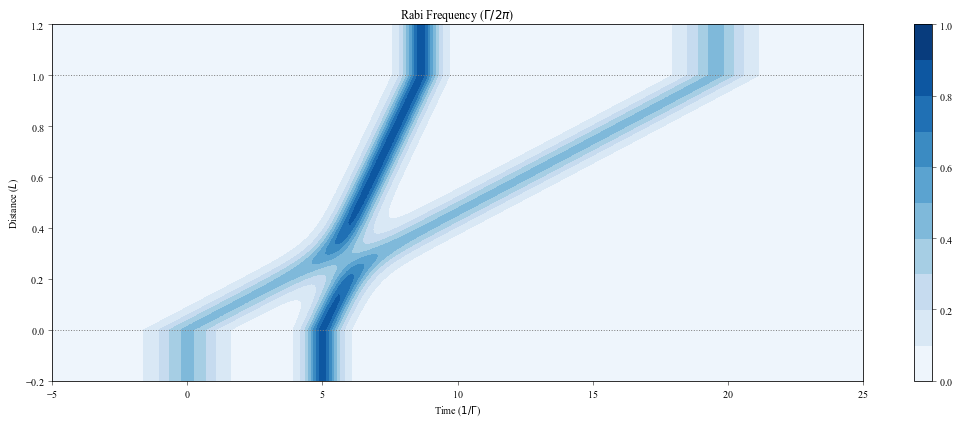

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import numpy as np

fig = plt.figure(1, figsize=(16, 6))
ax = fig.add_subplot(111)
cmap_range = np.linspace(0.0, 1.0, 11)
cf = ax.contourf(mb_solve_00.tlist, mb_solve_00.zlist, 
                 np.abs(mb_solve_00.Omegas_zt[0]/(2*np.pi)), 
                 cmap_range, cmap=plt.cm.Blues)
ax.set_title('Rabi Frequency ($\Gamma / 2\pi $)')
ax.set_xlabel('Time ($1/\Gamma$)')
ax.set_ylabel('Distance ($L$)')
for y in [0.0, 1.0]:
    ax.axhline(y, c='grey', lw=1.0, ls='dotted')
plt.colorbar(cf)
plt.savefig('images/mb-solve-two-sech-2pi-collision.png')

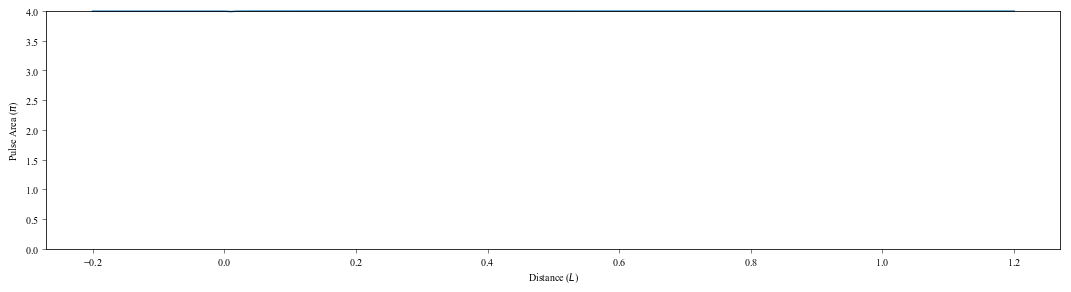

In [10]:
fig, ax = plt.subplots(figsize=(16, 4))
ax.plot(mb_solve_00.zlist, mb_solve_00.fields_area()[0]/np.pi, clip_on=False)
ax.set_ylim([0.0, 4.0])
ax.set_xlabel('Distance ($L$)')
ax.set_ylabel('Pulse Area ($\pi$)');

## Fixed Frame

In [11]:
from maxwellbloch import fixed

speed_of_light = 0.2 # [L Γ]

tlist_fixed_frame = fixed.t_list(mb_solve_00, speed_of_light)
field_fixed_frame = fixed.rabi_freq_abs(mb_solve_00, 0, speed_of_light);

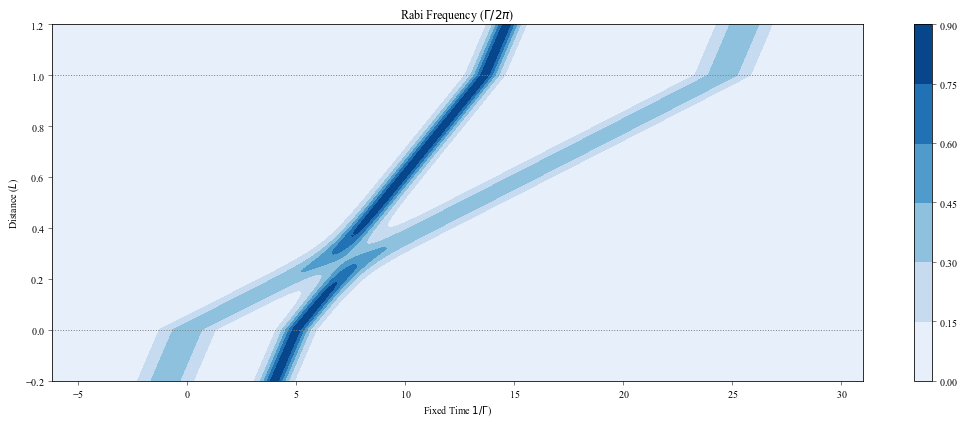

In [13]:
fig = plt.figure(2, figsize=(16, 6))
ax = fig.add_subplot(111)
# cmap_range = np.linspace(0.0, 1.0e-3, 11)
cf = ax.contourf(tlist_fixed_frame, mb_solve_00.zlist, 
                 field_fixed_frame/(2*np.pi), 
#                  cmap_range, 
                 cmap=plt.cm.Blues)
ax.set_title('Rabi Frequency ($\Gamma / 2\pi $)')
ax.set_xlabel('Fixed Time $1/\Gamma$)')
ax.set_ylabel('Distance ($L$)')
for y in [0.0, 1.0]:
    ax.axhline(y, c='grey', lw=1.0, ls='dotted')
plt.colorbar(cf)